# Extractive Summary of News

## 1. Storing data sets in memory

In [1]:
ARTICLES_PATH = 'BBC News Summary/News Articles'
SUMMARIES_PATH = 'BBC News Summary/Summaries'
ENCODING = 'latin1'

# CLASSES = ['sport', 'entertainment', 'tech', 'politics', 'business']
TRAIN_PERCENTAGE = 0.9

# DICTIONARY INDEXES
FILE_NAME = 0
TITLE_WORDS = 1
TITLE_UNIGRAMS = 2
TITLE_BIGRAMS = 3
TITLE_FOURGRAMS = 4
FILE_SENTENCES = 5
FILE_UNIGRAMS = 6
FILE_BIGRAMS = 7
FILE_FOURGRAMS = 8
SUMMARY_TEXT = 9
SUMMARY_UNIGRAMS = 10
SUMMARY_BIGRAMS = 10
SUMMARY_FOURGRAMS = 10

In [5]:
import nltk
# Uncomment if needed
# nltk.download('all')

In [6]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_words(initial_words):
    return list(filter(lambda x: lemmatizer.lemmatize(x), initial_words))

def filter_stop_words(initial_words):
    return list(filter(lambda x : x not in stop_words, initial_words))

def only_nouns(word_list):
    return [word for (word, tag) in pos_tag(word_list) if tag[:2] == 'NN']

In [63]:
import os
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk import ngrams

def get_summary_text_for_article(class_name, file_name):
    summary_directory_path = os.path.join(SUMMARIES_PATH, class_name)
    summary_file_path = os.path.join(summary_directory_path, file_name)
    with open (summary_file_path, 'r', encoding = ENCODING) as file:
        return file.read()

def n_grams(text, n):
    return list(ngrams(text, n))
    
def prepare_sentence_words(sentence, data_set_creation_info):
    result = word_tokenize(sentence)
    
    if data_set_creation_info['exclude_stop_words']:
        result = filter_stop_words(result)
    
    result = lemmatize_words(result)
    result = only_nouns(result)

    return result
    
def persist_article_class_file(data_set, data_set_creation_info, class_name, file_name, file_path):
    with open (file_path, 'r', encoding = ENCODING) as file:
        # Title
        file_title = file.readline()

        title_words = prepare_sentence_words(file_title, data_set_creation_info)
        title_unigrams = n_grams(title_words, 1)
        title_bigrams = n_grams(title_words, 2)
        title_fourgrams = n_grams(title_words, 4)
        
        file.readline()

        # Content
        file_content = file.read()
        
        file_sentences = list(map(lambda sentence : prepare_sentence_words(sentence, data_set_creation_info),\
            sent_tokenize(file_content)))
        file_unigrams = list(map(lambda sentence : n_grams(sentence, 1), file_sentences))
        file_bigrams = list(map(lambda sentence : n_grams(sentence, 2), file_sentences))
        file_fourgrams = list(map(lambda sentence : n_grams(sentence, 4), file_sentences))
        
        # Summary
        summary_text = get_summary_text_for_article(class_name, file_name)
        summary_tokens = word_tokenize(summary_text)
        summary_unigrams = n_grams(summary_tokens, 1)
        summary_bigrams = n_grams(summary_tokens, 2)
        summary_fourgrams = n_grams(summary_tokens, 4)
        
        
        # Wrapper
        new_information = (file_name, \
                           title_words, \
                           title_unigrams, \
                           title_bigrams, \
                           title_fourgrams, \
                           sent_tokenize(file_content), \
                           file_unigrams, \
                           file_bigrams, \
                           file_fourgrams, \
                           summary_text, \
                           summary_unigrams, \
                           summary_bigrams, \
                           summary_fourgrams)
    
        if class_name in data_set:
            new_value = data_set[class_name]
            new_value.append(new_information)
            data_set[class_name] = new_value
        else:
            data_set[class_name] = [new_information]
    return data_set

def persist_article_class(data_set, data_set_creation_info, class_name, class_directory_path):
    for file_name in os.listdir(class_directory_path):
        persist_article_class_file(data_set, data_set_creation_info, class_name,\
                file_name, os.path.join(class_directory_path, file_name))

def persist_articles_information(data_set_creation_info):
    data_set = dict()
    for class_directory in os.listdir(ARTICLES_PATH):
        persist_article_class(data_set, data_set_creation_info, class_directory,\
                os.path.join(ARTICLES_PATH, class_directory))
        
    return data_set

In [64]:
# Create dataset including stop words
data_set_creation_info = {'exclude_stop_words' : False}
data_set = persist_articles_information(data_set_creation_info)

# Create dataset with stop words excluded
data_set_creation_info = {'exclude_stop_words' : True}
data_set_stop_words_excluded = persist_articles_information(data_set_creation_info)

## 2. Building Models

In [65]:
from IPython.display import clear_output

def show_progress_bar(current_value, max_value, bar_length = 100):
    # compute bar properties
    ratio = current_value / max_value
    current_bar_length = int(ratio * bar_length)
    
    # compute bar
    current_bar_array = [' '] * bar_length
    for i in range(0, current_bar_length):
        current_bar_array[i] = '#'
    bar_string = functools.reduce(operator.add, current_bar_array)
    
    # print bar
    clear_output(wait = True)
    print("[{}] {}%".format(bar_string, int(ratio * 100)))

In [66]:
def split_data(data_set):
    train_data = dict()
    test_data = dict()
    
    for class_name in data_set:
        data_array = data_set[class_name]
        total_data_length = len(data_array)
        
        cutoff_index = int(total_data_length * TRAIN_PERCENTAGE)
        
        train_data[class_name] = data_array[0: cutoff_index]
        test_data[class_name] = data_array[cutoff_index:total_data_length]    
        
    return train_data, test_data

### 2.1) Term Frequency–Inverse Document Frequency (TF-IDF) models

In [67]:
import functools
import operator
from math import log

def count_term_frequency(item, items_matrix):
    count = 0
    for i in range(0, len(items_matrix)):
        for j in range(0, len(items_matrix[i])):
            if items_matrix[i][j] == item:
                count += 1
    return count

def count_inverse_document_frequency(item, class_data, content_index):
    count = 0
    # for each document
    for article_information in class_data:
        items_matrix = article_information[content_index]
        # for each sentence
        for i in range(0, len(items_matrix)):
            
            # if found in any sentence => found in article 
            if item in items_matrix[i]:
                count+=1
                continue

    return count

def compute_tf_idf(train_data, content_index, title_index):
    N = 0
    tf_idf_model = dict()
    for class_name in train_data:
        tf_idf_model[class_name] = dict()
        N += len(train_data[class_name])

    index = 1
    for class_name in train_data:
        class_data = train_data[class_name]
        
        for article_information in class_data:
            show_progress_bar(index, N)
            n_gram_matrix = article_information[content_index]
            for i in range(0, len(n_gram_matrix)):
                for j in range(0, len(n_gram_matrix[i])):
                    n_gram = n_gram_matrix[i][j]
                    term_frequency = count_term_frequency(n_gram, article_information[content_index])
                    inverse_document_frequency = count_inverse_document_frequency(n_gram, class_data, content_index)

                    tf_idf = term_frequency * log(N / inverse_document_frequency)
                    
                    if n_gram in tf_idf_model[class_name]:
                        new_value = tf_idf_model[class_name][n_gram]
                        new_value += tf_idf
                        tf_idf_model[class_name][n_gram] = new_value
                    else:
                        tf_idf_model[class_name][n_gram] = tf_idf
                    
            index += 1
    
    return tf_idf_model

In [68]:
train_data_tf_idf, test_data_tf_idf = split_data(data_set_stop_words_excluded)

In [28]:
tf_idf_unigram_model = compute_tf_idf(train_data_tf_idf, FILE_UNIGRAMS, TITLE_UNIGRAMS)

[####################################################################################################] 100%


In [29]:
tf_idf_bigram_model = compute_tf_idf(train_data_tf_idf, FILE_BIGRAMS, TITLE_BIGRAMS)

[####################################################################################################] 100%


In [30]:
tf_idf_fourgram_model = compute_tf_idf(train_data_tf_idf, FILE_FOURGRAMS, TITLE_FOURGRAMS)

[####################################################################################################] 100%


### 2.2) Naive Bayes models

In [87]:
FOUND = 0
NOT_FOUND = 1
DICTIONARY_LENGTH = 2

def is_found_in_summary(item, items_list):
    for x in items_list:
        if item == x:
            return True
    return False

def compute_bayes_model(train_data, content_index, summary_index):
    N = 0
    bayes_model = dict()
    for class_name in train_data:
        bayes_model[class_name] = dict()
        N += len(train_data[class_name])

    index = 1
    for class_name in train_data:
        class_data = train_data[class_name]
        
        for article_information in class_data:
            show_progress_bar(index, N)
            n_gram_matrix = article_information[content_index]
            for i in range(0, len(n_gram_matrix)):
                for j in range(0, len(n_gram_matrix[i])):
                    found = 0
                    not_found = 0
                    
                    n_gram = n_gram_matrix[i][j]
                    
                    if is_found_in_summary(n_gram, article_information[summary_index]):
                        found += 1
                    else:
                        not_found += 1
                        
                    if n_gram in bayes_model[class_name]:
                        found_history, not_found_history = bayes_model[class_name][n_gram]
                        bayes_model[class_name][n_gram] = (found_history + found, not_found_history + not_found)
                    else:
                        bayes_model[class_name][n_gram] = (found, not_found)
            index += 1
    
    return bayes_model

#### 2.2.1) Stop words included

In [70]:
train_data, test_data = split_data(data_set)

In [71]:
bayes_unigram_model = compute_bayes_model(train_data, FILE_UNIGRAMS, SUMMARY_UNIGRAMS)

[####################################################################################################] 100%


In [72]:
bayes_bigram_model = compute_bayes_model(train_data, FILE_BIGRAMS, SUMMARY_BIGRAMS)

[####################################################################################################] 100%


In [73]:
bayes_fourgram_model = compute_bayes_model(train_data, FILE_BIGRAMS, SUMMARY_FOURGRAMS)

[####################################################################################################] 100%


#### 2.2.1) Stop words excluded

In [76]:
train_data_stop_words_excluded, test_data_stop_words_excluded = split_data(data_set_stop_words_excluded)

In [79]:
bayes_unigram_model_stop_words_excluded = \
        compute_bayes_model(train_data_stop_words_excluded, FILE_UNIGRAMS, SUMMARY_UNIGRAMS)

[####################################################################################################] 100%


In [80]:
bayes_bigram_model_stop_words_excluded = \
        compute_bayes_model(train_data_stop_words_excluded, FILE_BIGRAMS, SUMMARY_BIGRAMS)

[####################################################################################################] 100%


In [82]:
bayes_fourgram_model_stop_words_excluded = \
        compute_bayes_model(train_data_stop_words_excluded, FILE_FOURGRAMS, SUMMARY_FOURGRAMS)

[####################################################################################################] 100%


## 3. Produce Summary

### 3.1 TF-IDF

In [83]:
import numpy as np
TITLE_IMPORTANCE = 0.1
K = 3

def generate_sentence_smoother_sequence(number_of_sentences):
    SENTENCE_ORDER_LOWER_BOUND = 0.1
    SENTENCE_ORDER_UPPER_BOUND = 1
    return np.linspace(SENTENCE_ORDER_LOWER_BOUND, SENTENCE_ORDER_UPPER_BOUND, number_of_sentences)

def count_of_words_in_title(n_gram_sentence, title_n_grams):
    count = 0
    for n_gram in n_gram_sentence:
        if n_gram in title_n_grams:
            count += 1
    return count

def produce_summary_for_class(model, test_data, class_name, \
        article_information, file_n_grams_index, title_n_grams_index):
    sentences = []
    sentences_length = len(article_information[FILE_SENTENCES])
    for i in range(0, sentences_length):
        actual_sentence = article_information[FILE_SENTENCES][i]
        n_gram_sentence = article_information[file_n_grams_index][i]
        
        sentence_score = 0
        
        # step 1 (Importance of nouns)
        nouns_score = 0
        for n_gram in n_gram_sentence:
            if n_gram in model[class_name]:
                nouns_score += model[class_name][n_gram]
        
        sentence_score = nouns_score / (len(n_gram_sentence) + 1)
        
        # step 2 (Relation with title)
        words_in_title = count_of_words_in_title(n_gram_sentence, article_information[title_n_grams_index])
        title_score = words_in_title * TITLE_IMPORTANCE
        
        sentence_score += title_score
        
        sentences.append((actual_sentence, sentence_score))
    
    # step 3 (Smoothing sentences with respect to their position in article)
    sentence_smoother = generate_sentence_smoother_sequence(sentences_length)
    for i in range(0, sentences_length):
        text, score = sentences[i] 
        new_score = score * sentence_smoother[i]
        sentences[i] = (text, new_score) 
    
    # step 4 (Fetch only the first K sentences with highest score)
    sentences.sort(reverse = True, key = lambda x : x[1])
    
    # chose upper bound
    upper_bound = K if K <= sentences_length else sentences_length 
    
    # filter out the score
    sentences_test_list = list(map(lambda x: x[0], sentences[0:upper_bound]))
    
    # concat sentences
    return functools.reduce(operator.add, sentences_test_list)
    
def produce_summary_tf_idf(model, test_data, file_n_grams_index, title_n_grams_index):
    results = []
    for class_name in test_data:
        class_data = test_data[class_name]
        
        for article_information in class_data:
            computed_summary = produce_summary_for_class(\
                model, test_data, class_name, article_information, file_n_grams_index, title_n_grams_index)
            results.append((class_name, article_information, computed_summary))
    return results

In [84]:
tf_idf_unigrams_results = \
        produce_summary_tf_idf(tf_idf_unigram_model, test_data_tf_idf, FILE_UNIGRAMS, TITLE_UNIGRAMS)
tf_idf_bigrams_results = \
        produce_summary_tf_idf(tf_idf_bigram_model, test_data_tf_idf, FILE_BIGRAMS, TITLE_FOURGRAMS)
tf_idf_fourgrams_results = \
        produce_summary_tf_idf(tf_idf_bigram_model, test_data_tf_idf, FILE_BIGRAMS, TITLE_FOURGRAMS)

### 3.2 Bayes

In [113]:
def get_model_global_information(model, data_set):
    model_information = dict()
    
    for class_name in data_set:
        model_for_class = model[class_name]
        
        total_found = 0
        total_not_found = 0
        for n_gram in model_for_class:
            history_found, history_not_found = model_for_class[n_gram]
            total_found += history_found
            total_not_found += history_not_found
        
        
        total = total_found + total_not_found
        model_information[class_name] = (total_found, total_not_found, len(model_for_class))
    return model_information

def produce_summary_for_class_bayes(model, model_information, class_name, article_information,\
        file_n_grams_index, alpha = 0.8):
    class_total_found = model_information[class_name][FOUND]
    class_total_not_found = model_information[class_name][NOT_FOUND]
    class_total = class_total_found + class_total_not_found 
    
    log_found = log(class_total_found / class_total)
    log_not_found = log(class_total_not_found / class_total)
    dictionary_length = model_information[class_name][DICTIONARY_LENGTH]
    
    sentences = []
    sentences_length = len(article_information[FILE_SENTENCES])
    for i in range(0, sentences_length):
        actual_sentence = article_information[FILE_SENTENCES][i]
        n_gram_sentence = article_information[file_n_grams_index][i]
        
        log_n_gram_found = 0
        log_n_gram_not_found = 0

        for n_gram in n_gram_sentence:
            if n_gram in model[class_name]:
                (found_count, not_found_count) = model[class_name][n_gram] 
                log_n_gram_found += \
                    log((found_count + alpha) / (class_total_found + dictionary_length * alpha))
                log_n_gram_found += \
                    log((not_found_count + alpha) / (class_total_not_found + dictionary_length * alpha))
        
        if log_found + log_n_gram_found >= log_not_found + log_n_gram_not_found:
            sentences.append((actual_sentence, True))
        else:
            sentences.append((actual_sentence, False))
    
    # filter out the sentences that we presume are not part of the summary
    sentences = list(filter(lambda x: x[1] == True, sentences))
    
    # filter out the decision
    sentences_test_list = list(map(lambda x: x[0], sentences))
    
    # concat sentences
    return functools.reduce(operator.add, sentences_test_list, "")
    
def produce_summary_bayes(data_set, model, file_n_grams_index):
    N = 0
    for class_name in data_set:
        N += len(data_set[class_name])

    index = 1
    results = []
    for class_name in data_set:
        class_data = data_set[class_name]
        
        for article_information in class_data:
            show_progress_bar(index, N)
            computed_summary = produce_summary_for_class_bayes(model, \
                get_model_global_information(bayes_unigram_model, data_set),\
                class_name,\
                article_information,\
                file_n_grams_index)
            results.append((class_name, article_information, computed_summary))
            index += 1
            
    return results

### 3.2.1) Stop words included

In [114]:
bayes_unigrams_results = produce_summary_bayes(test_data, bayes_unigram_model, FILE_UNIGRAMS)

[####################################################################################################] 100%


In [115]:
bayes_bigrams_results = produce_summary_bayes(test_data, bayes_bigram_model, FILE_BIGRAMS)

[####################################################################################################] 100%


In [116]:
bayes_fourgrams_results = produce_summary_bayes(test_data, bayes_fourgram_model, FILE_BIGRAMS)

[####################################################################################################] 100%


### 3.2.2) Stop words excluded

In [117]:
bayes_unigrams_results_stop_words_excluded = \
        produce_summary_bayes(test_data_stop_words_excluded, bayes_unigram_model, FILE_UNIGRAMS)

[####################################################################################################] 100%


In [118]:
bayes_bigrams_results_stop_words_excluded = \
        produce_summary_bayes(test_data_stop_words_excluded, bayes_bigram_model, FILE_BIGRAMS)

[####################################################################################################] 100%


In [119]:
bayes_fourgrams_results_stop_words_excluded = \
        produce_summary_bayes(test_data_stop_words_excluded, bayes_fourgram_model, FILE_FOURGRAMS)

[####################################################################################################] 100%


## 4 Draw results

In [95]:
import matplotlib.pyplot as plt

In [96]:
def n_grams(text, n):
    return list(ngrams(text.split(), n))

def common(list1, list2): 
    return set(list1).intersection(list2)

def bleu_n(results, n_gram_identifier):
    total_common_grams = 0
    total_text_grams = 0
    for result in results:
        expected = n_grams(result[1][SUMMARY_TEXT], n_gram_identifier)
        actual = n_grams(result[2], n_gram_identifier)
        common_grams = common(expected, actual)
        total_common_grams += len(common_grams) 
        total_text_grams += len(actual)
        
    return total_common_grams / total_text_grams * 100

def rouge_n(results, n_gram_identifier):
    total_common_grams = 0
    total_text_grams = 0
    for result in results:
        expected = n_grams(result[1][SUMMARY_TEXT], n_gram_identifier)
        actual = n_grams(result[2], n_gram_identifier)
        common_grams = common(expected, actual)
        total_common_grams += len(common_grams) 
        total_text_grams += len(expected)
        
    return total_common_grams / total_text_grams * 100

### 4.1 TF-IDF

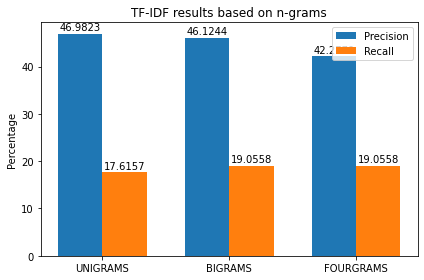

In [101]:
labels = ['UNIGRAMS', 'BIGRAMS', 'FOURGRAMS']

precision = [bleu_n(tf_idf_unigrams_results, 1), \
             bleu_n(tf_idf_bigrams_results, 2), \
             bleu_n(tf_idf_fourgrams_results, 4)]

recall = [rouge_n(tf_idf_unigrams_results, 1), \
          rouge_n(tf_idf_bigrams_results, 1),\
          rouge_n(tf_idf_fourgrams_results, 1)]

# label locations
x = np.arange(len(labels))  
# bars width
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision, width, label='Precision')
rects2 = ax.bar(x + width/2, recall, width, label='Recall')

ax.set_ylabel('Percentage')
ax.set_title('TF-IDF results based on n-grams')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)

fig.tight_layout()
plt.show()

### 4.3 Bayes

### 4.3.1) Stop words included

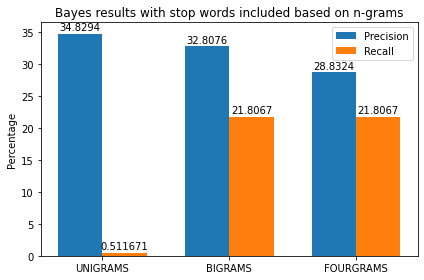

In [120]:
labels = ['UNIGRAMS', 'BIGRAMS', 'FOURGRAMS']
precision = [bleu_n(bayes_unigrams_results, 1), \
             bleu_n(bayes_bigrams_results, 2), \
             bleu_n(bayes_fourgrams_results, 4)]

recall = [rouge_n(bayes_unigrams_results, 1), \
          rouge_n(bayes_bigrams_results, 1),\
          rouge_n(bayes_fourgrams_results, 1)]

# label locations
x = np.arange(len(labels))  
# bars width
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision, width, label='Precision')
rects2 = ax.bar(x + width/2, recall, width, label='Recall')

ax.set_ylabel('Percentage')
ax.set_title('Bayes results with stop words included based on n-grams')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)

fig.tight_layout()
plt.show()

### 4.3.1) Stop words excluded

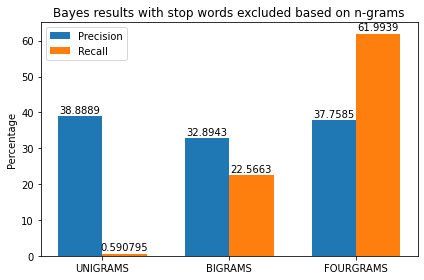

In [121]:
labels = ['UNIGRAMS', 'BIGRAMS', 'FOURGRAMS']
precision = [bleu_n(bayes_unigrams_results_stop_words_excluded, 1), \
             bleu_n(bayes_bigrams_results_stop_words_excluded, 2), \
             bleu_n(bayes_fourgrams_results_stop_words_excluded, 4)]

recall = [rouge_n(bayes_unigrams_results_stop_words_excluded, 1), \
          rouge_n(bayes_bigrams_results_stop_words_excluded, 1),\
          rouge_n(bayes_fourgrams_results_stop_words_excluded, 1)]

# label locations
x = np.arange(len(labels))  
# bars width
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision, width, label='Precision')
rects2 = ax.bar(x + width/2, recall, width, label='Recall')

ax.set_ylabel('Percentage')
ax.set_title('Bayes results with stop words excluded based on n-grams')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)

fig.tight_layout()
plt.show()